In [ ]:


# SetFit funktioniert aktuell nicht mit Transformers 5.x. Beim Import knallt es
# mit einem ImportError (default_logdir wurde in 5.0 entfernt).
# Deshalb pinnen wir Transformers auf 4.x, bis SetFit das gefixt hat.
# Siehe: https://github.com/huggingface/setfit/issues/629


!pip install -U -q "transformers<5.0" setfit datasets sentence-transformers scikit-learn seaborn matplotlib "pandas<2.3.0"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import torch
import numpy as np
import os
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from datasets import Dataset
from setfit import SetFitModel, Trainer, TrainingArguments

# Ggf folgendes noch ausführen
# from google.colab import drive
# drive.mount('/content/drive')

# Warnungen unterdrücken und Umgebung konfigurieren
warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Laden der CSV-Datei aus meinem Google Drive Verzeichnis
daten = pd.read_csv('/content/drive/MyDrive/data_PDA_labeled.csv', sep=';', encoding='latin1')

# Whitespace-Bereinigung:
# Damit Firmen wie "Bosch " und "Bosch" als identisch erkannt werden.
# Sonst funktioniert der Group-Split später nicht sauber (Data Leakage Gefahr).
daten['firma'] = daten['company_name'].astype(str).str.strip()
daten['text_segment'] = daten['text_segment'].astype(str).str.strip()

In [ ]:
# Vermeidung des Reihefolgen-Bias
daten = daten.sample(frac=1, random_state=42).reset_index(drop=True)

# Labels von CSV-String "1,3" wird in Liste [1, 3] umgewandelt
daten['label_liste'] = daten['labels'].apply(lambda x: [int(t) for t in str(x).split(',')])

# One-Hot-Encoding für Multi-Label-Klassifikation (8 Klassen)
mlb = MultiLabelBinarizer(classes=list(range(1, 9)))
daten['label_onehot'] = list(mlb.fit_transform(daten['label_liste']))

# Dictionary für Beschriftung der Grafiken
Kategorien = {1: "I. Battery/HV-Systeme", 2: "II. E-Antrieb/Leistungselektronik", 3: "III. Thermomanagement", 4: "IV. Fahrzeugplattform/Hardware",
                  5: "V. Ladeinfrastruktur (off-board)", 6: "VI. Digital Car/Software", 7: "VII. Legacy/Alternative Antriebe", 8: "VIII. Irrelevant"}

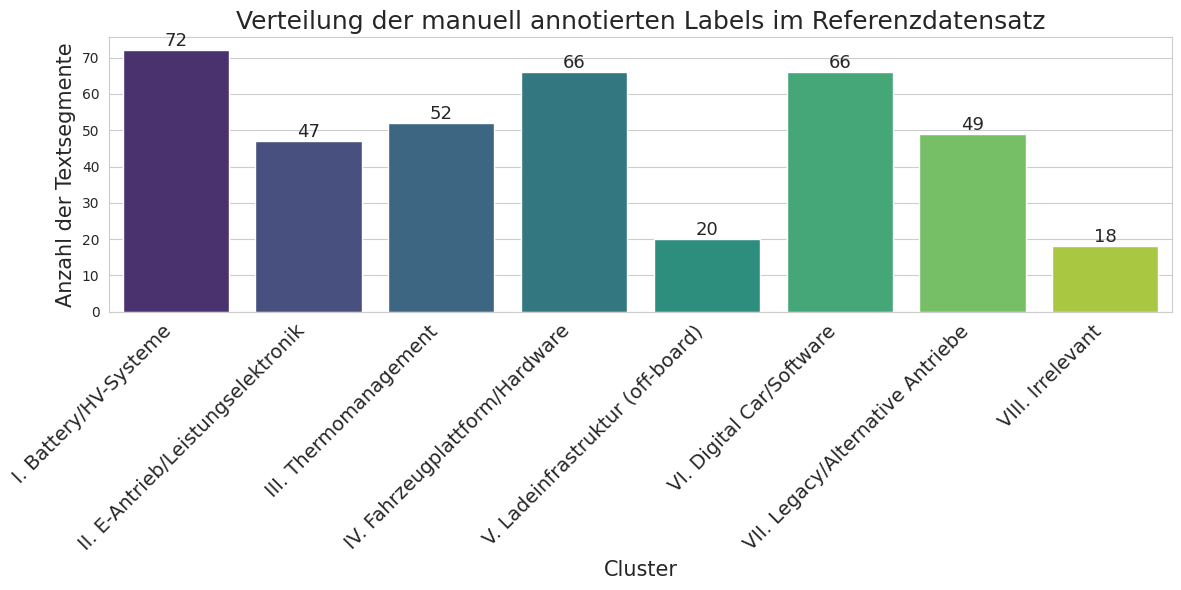

In [ ]:

daten_pro_label = daten.explode('label_liste')
verteilung = daten_pro_label['label_liste'].value_counts().reindex(range(1, 9), fill_value=0)
verteilung.index = [Kategorien[i] for i in verteilung.index]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=verteilung.index, y=verteilung.values, palette="viridis")

# Zahlen auf die Balken schreiben
for c in ax.containers:
    ax.bar_label(c, fmt='%d', fontsize=13)

plt.title("Verteilung der manuell annotierten Labels im Referenzdatensatz", fontsize=18)
plt.xlabel("Cluster", fontsize=15)
plt.ylabel("Anzahl der Textsegmente", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:


kfold_gruppen = GroupKFold(n_splits=3)
metriken = {'macro': [], 'micro': [], 'weighted': []}
oof_vorhersagen = np.zeros((len(daten), 8), dtype=int)

for runde, (train_idx, test_idx) in enumerate(kfold_gruppen.split(daten, groups=daten['firma'])):
    train_daten = daten.iloc[train_idx]
    test_daten  = daten.iloc[test_idx]

    # Konvertierung der Pandas-DataFrames in das von der Hugging Face Bibliothek benötigte Format.
    ds_train = Dataset.from_pandas(train_daten[['text_segment', 'label_onehot']].rename(columns={'text_segment':'text', 'label_onehot':'label'}))
    ds_test  = Dataset.from_pandas(test_daten[['text_segment', 'label_onehot']].rename(columns={'text_segment':'text', 'label_onehot':'label'}))

    modell = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2", multi_target_strategy="one-vs-rest")

    # Konfiguration des Trainers
    trainer = Trainer(model=modell, args=TrainingArguments(num_epochs=3, batch_size=16, num_iterations=20, seed=42, report_to="none"),
        train_dataset=ds_train
    )
    trainer.train()

    # Vorhersage auf dem Test-Set
    vorhersagen = modell.predict(ds_test['text'])

    # Speichern der Vorhersagen im globalen OOF-Array
    oof_vorhersagen[test_idx] = vorhersagen

    # Evaluation der aktuellen Fold-Performance
    wahrheit = np.array(ds_test['label'])
    metriken['macro'].append(f1_score(wahrheit, vorhersagen, average='macro', zero_division=0))
    metriken['micro'].append(f1_score(wahrheit, vorhersagen, average='micro', zero_division=0))
    metriken['weighted'].append(f1_score(wahrheit, vorhersagen, average='weighted', zero_division=0))

    print(f"Runde {runde+1} | Macro: {metriken['macro'][-1]:.1%} | Micro: {metriken['micro'][-1]:.1%} | Weighted: {metriken['weighted'][-1]:.1%}")

    # Freigabe des belegten VRAMs (GPU-Speicher) und RAMs nach jedem Fold,
    # um Speicherüberläufe (Out-of-Memory Errors) während der Cross-Validation zu verhindern.
    del modell, trainer
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/190 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7600
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.305200
50,0.246800
100,0.206800
150,0.184100
200,0.162300
250,0.137500
300,0.128900
350,0.111500
400,0.100000
450,0.084800


Runde 1 | Macro: 50.7% | Micro: 65.5% | Weighted: 63.2%


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7640
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.487800
50,0.249600
100,0.206900
150,0.186300
200,0.159900
250,0.142900
300,0.138400
350,0.106900
400,0.111100
450,0.095100


Runde 2 | Macro: 55.9% | Micro: 70.8% | Weighted: 66.5%


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/189 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7560
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.351000
50,0.255700
100,0.205300
150,0.174700
200,0.151500
250,0.128200
300,0.116300
350,0.109600
400,0.107800
450,0.095100


Runde 3 | Macro: 43.5% | Micro: 57.3% | Weighted: 52.5%


In [ ]:

print(f"Durchschnitt über alle Folds:")
print(f"Macro-F1: {np.mean(metriken['macro']):.1%} ± {np.std(metriken['macro']):.1%}")
print(f"Weighted-F1: {np.mean(metriken['weighted']):.1%} ± {np.std(metriken['weighted']):.1%}")
print(f"Micro-F1: {np.mean(metriken['micro']):.1%} ± {np.std(metriken['micro']):.1%}")

# Wenn das Modell gar nichts vorhersagt (leere Liste), wird '8' (Irrelevant) zugewiesen.
daten['ML_labels'] = [list(x) if len(x) > 0 else [8] for x in mlb.inverse_transform(oof_vorhersagen)]

Durchschnitt über alle Folds:
Macro-F1: 50.0% ± 5.1%
Weighted-F1: 60.7% ± 6.0%
Micro-F1: 64.5% ± 5.6%


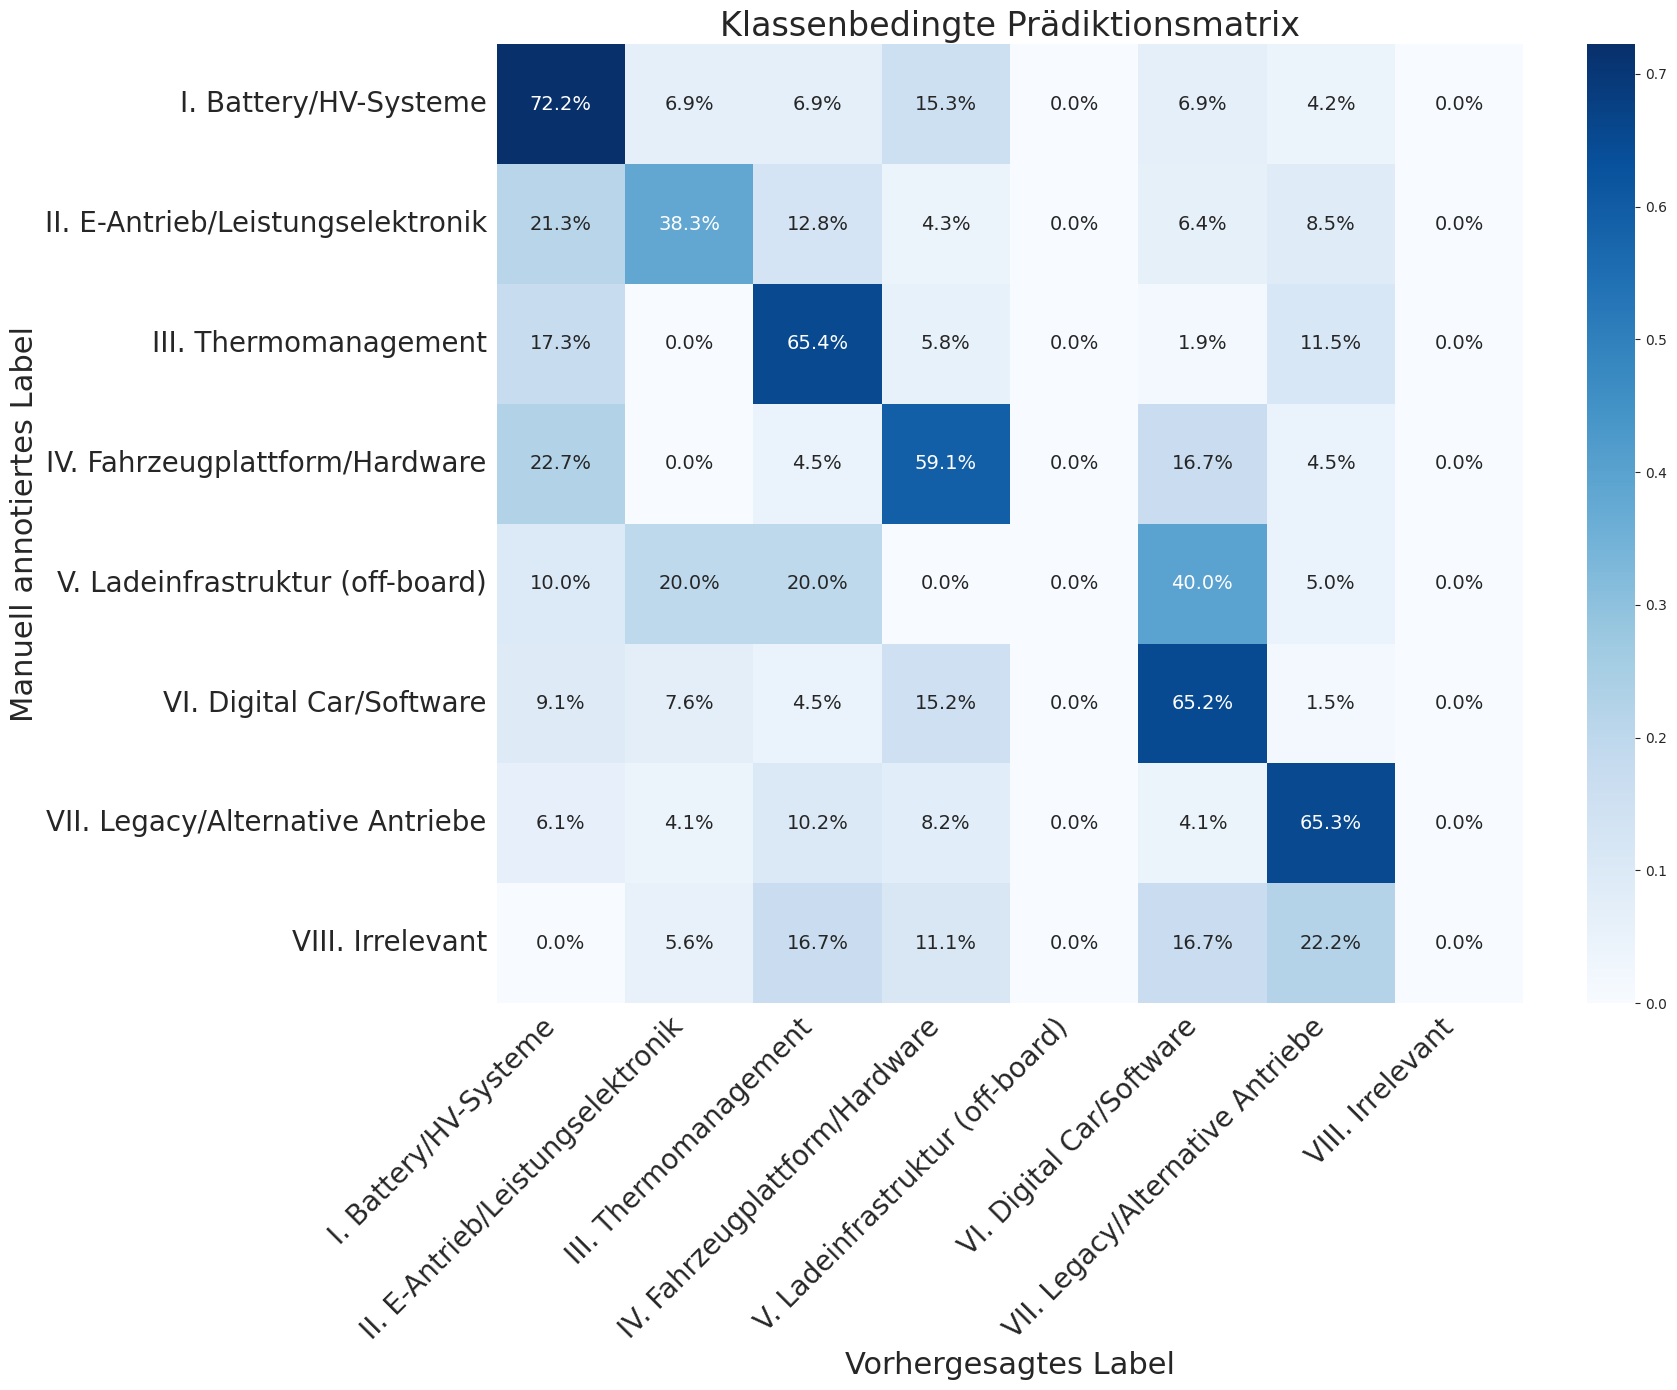

In [ ]:
# Klassenbedingte Prädiktionsmatrix: Für jede Klasse c wird der Anteil
# der Segmente berechnet, für die das Modell Klasse p vorhersagt.
# Diagonale = Recall, Off-Diagonale = Ko-Prädiktionsraten.

y_true_matrix = np.array(list(daten['label_onehot']))
y_pred_matrix = oof_vorhersagen

label_ids = list(range(1, 9))
cm = np.zeros((8, 8))

for c in range(8):
    # Alle Segmente, bei denen Cluster c tatsächlich vorliegt
    maske = y_true_matrix[:, c] == 1
    n_true = maske.sum()
    if n_true > 0:
        for p in range(8):
            # Anteil dieser Segmente, für die das Modell Cluster p vorhersagt
            cm[c, p] = y_pred_matrix[maske, p].sum() / n_true

plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues', annot_kws={"size": 14}, xticklabels=[Kategorien[i] for i in label_ids], yticklabels=[Kategorien[i] for i in label_ids])
plt.title('Klassenbedingte Prädiktionsmatrix', fontsize=24)
plt.xlabel('Vorhergesagtes Label', fontsize=22)
plt.ylabel('Manuell annotiertes Label', fontsize=22)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.tight_layout()
plt.show()

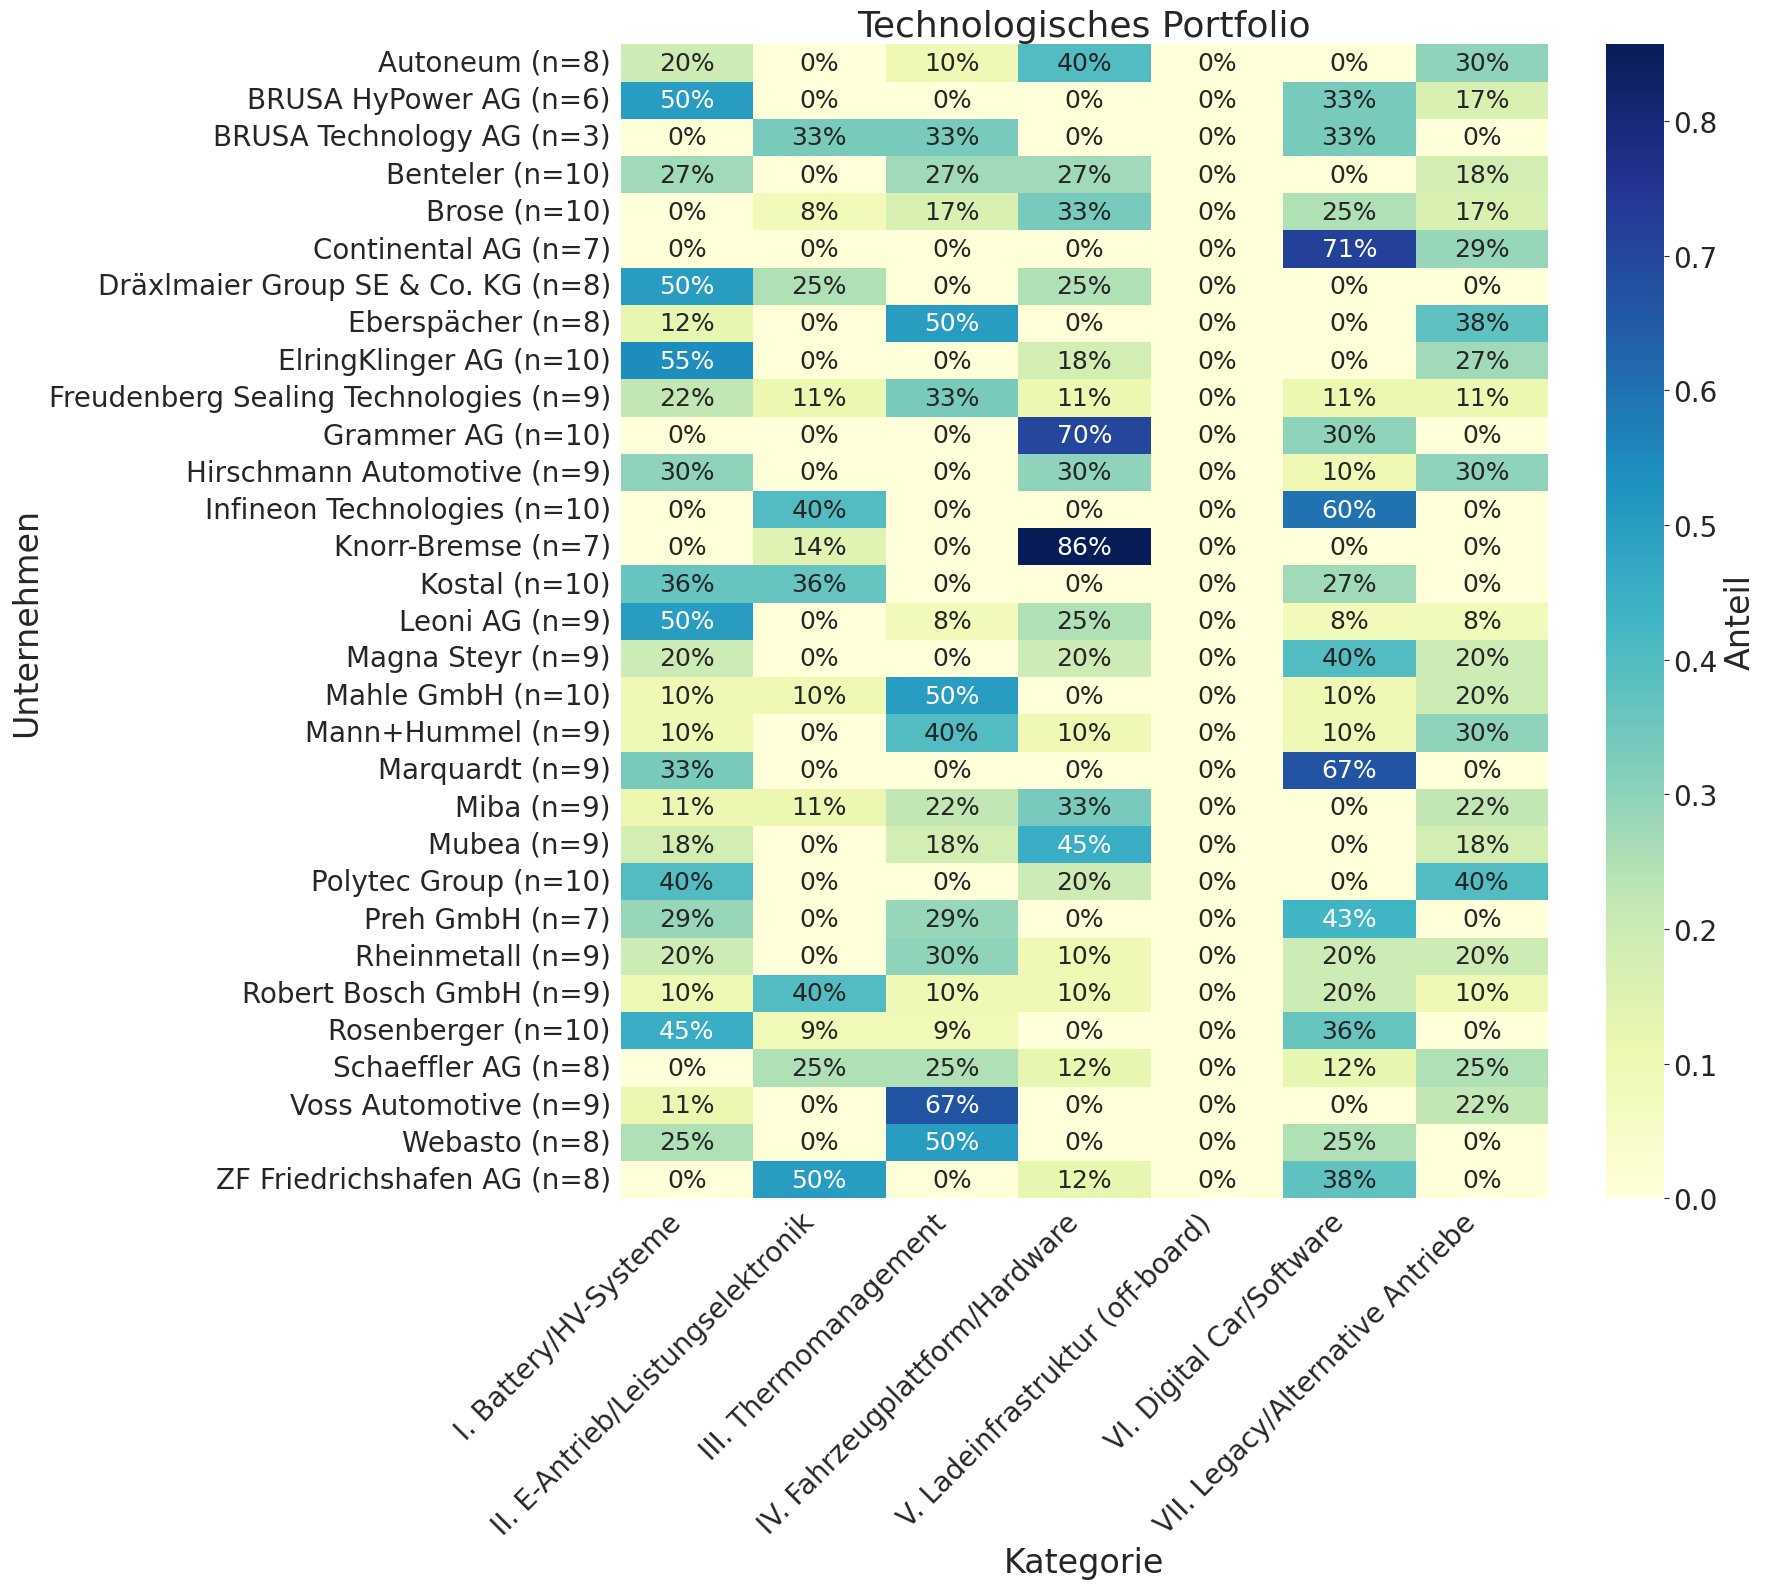

In [ ]:
# Technologie-Profile der Unternehmen als Heatmap.

# Label 8 (Irrelevant) wird aus den Vorhersagen entfernt, nicht das ganze Segment.
# So geht z.B. bei einer Vorhersage [4, 8] die Cluster-4-Info nicht verloren.
heatmap_daten = daten.copy()
heatmap_daten['ML_labels_clean'] = heatmap_daten['ML_labels'].apply(
    lambda x: [l for l in x if l != 8]
)
# Nur Segmente entfernen, die ausschließlich 8 enthielten (leere Liste nach Filter)
heatmap_daten = heatmap_daten[heatmap_daten['ML_labels_clean'].apply(len) > 0]

daten_explodiert = heatmap_daten.explode('ML_labels_clean')
daten_explodiert['Kategorie'] = daten_explodiert['ML_labels_clean'].map(Kategorien)

# Kreuztabelle: Firmen × Kategorien, zeilennormiert (relative Anteile pro Firma)
matrix = pd.crosstab(daten_explodiert['firma'], daten_explodiert['Kategorie'], normalize='index')

# Fehlende Kategorien mit 0% auffüllen
relevante_kats = [Kategorien[i] for i in range(1, 8)]
matrix = matrix.reindex(columns=relevante_kats, fill_value=0)

# Segmentzahl pro Firma anzeigen, damit man sieht wie belastbar die Profile sind
anzahl_segmente = heatmap_daten.groupby('firma').size()
matrix.index = [f"{firma} (n={anzahl_segmente.get(firma, 0)})" for firma in matrix.index]

# Plotting
plt.figure(figsize=(18, 16))
ax = sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt=".0%", cbar_kws={'label': 'Anteil'}, annot_kws={'size': 18})

cbar = ax.collections[0].colorbar
cbar.set_label('Anteil', fontsize=24)
cbar.ax.tick_params(labelsize=20)

plt.title('Technologisches Portfolio', fontsize=26)
plt.ylabel('Unternehmen', fontsize=24)
plt.xlabel('Kategorie', fontsize=24)
plt.xticks(rotation=45, ha="right", fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
